In [1]:
import glob
import urllib2
import qctoolkit as qtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import scipy as sp
plt.style.use('classic')

%matplotlib inline

# Data construction for Alanates

In [2]:
unit = 'ev'

E_Ca = -0.390 # in eV from materials project
E_Sr = -0.419 # in eV from materials project
dE = qtk.convE(E_Ca - E_Sr, 'eV-%s' % unit)[0]
print dE

# raw input sorted by names
ref_raw = qtk.pload('ref.pkl')
pred_raw = qtk.pload('pred.pkl')

0.029


Since E_Sr is lower, every Ca crystals need to be shifted upward by dE

In [3]:
# striping only experimental accessible Ca, Sr alanates
# ditching Mg related alanates

# for reference
ref_raw_all = []
ref_raw_ca = []
ref_raw_sr = []
for r in ref_raw:
    cyl, root = r.name.replace('.out', '').split('-')
    if 'Mg' not in cyl and 'Mg' not in root:
        
        #if 'Mg' not in root:
        if root!='Mg':
            ref_raw_all.append(r)
        if 'Ca' in root:
            ref_raw_ca.append(r)
        if 'Sr' in root:
            ref_raw_sr.append(r)
        #print cyl, root
        
# for prediction
pred_raw_all = []
pred_raw_ca = []
pred_raw_sr = []
for p in pred_raw:
    cyl, root = p.name.replace('out', '').split('-')
    if 'Mg' not in cyl and 'Mg' not in root:
        pred_raw_all.append(p)
        if '2Ca' in root:
            pred_raw_ca.append(p)
        if '2Sr' in root:
            pred_raw_sr.append(p)

In [4]:
true_ca_native_raw = []
true_sr_native_raw = []
true_all_native_raw = []
ref_ca_native_raw = []
ref_sr_native_raw = []

for o in ref_raw:
    cyl, root = o.name.replace('.out', '').split('-')
    cyl_root = cyl.split('_')[0]
    if root == 'Sr' and cyl_root == 'Sr':
        true_sr_native_raw.append(o)
    elif root == 'Ca' and cyl_root == 'Ca':
        true_ca_native_raw.append(o)
    elif root == 'Sr' and cyl_root == 'Ca':
        ref_ca_native_raw.append(o)
    elif root == 'Ca' and cyl_root == 'Sr':
        ref_sr_native_raw.append(o)
    if root == cyl_root and root in ['Ca', 'Sr']:
        true_all_native_raw.append(o)
        
        
print len(true_sr_native_raw)
print len(true_ca_native_raw)
print len(ref_sr_native_raw)
print len(ref_ca_native_raw)
print len(true_all_native_raw)

pred_ca_native_raw = []
pred_sr_native_raw = []
pred_all_native_raw = []

for o in pred_raw:
    cyl, root = o.name.replace('.out', '').split('-')
    cyl_root = cyl.split('_')[0]
    to_add = False
    if root == 'Ca2Sr' and cyl_root == 'Sr':
        pred_sr_native_raw.append(o)
        to_add = True
    elif root == 'Sr2Ca' and cyl_root == 'Ca':
        pred_ca_native_raw.append(o)
        to_add = True
    if to_add:
        pred_all_native_raw.append(o)

print len(pred_sr_native_raw)
print len(pred_ca_native_raw)
print len(pred_all_native_raw)

44
42
44
42
86
44
42
86


In [5]:
print "total number of crystals: ",
print len(ref_raw_all)
print "Ca crystals: ",
print len(ref_raw_ca)
print "Sr crystals: ",
print len(ref_raw_sr)
print "native + swapped = 2*(native)\n"
print "total number of predictions: ",
print len(pred_raw_all)
print "(each reference crystal gets one prediction)"
print "native + swapped Ca crystals predicted by Sr: ",
print len(pred_raw_ca)
print "native + swapped Sr crystals predicted by Ca: ",
print len(pred_raw_sr)

total number of crystals:  172
Ca crystals:  86
Sr crystals:  86
native + swapped = 2*(native)

total number of predictions:  172
(each reference crystal gets one prediction)
native + swapped Ca crystals predicted by Sr:  86
native + swapped Sr crystals predicted by Ca:  86


In [6]:
# construct ordering key

def reorder_ref(outs):
    diffs = []
    for k in range(len(outs)):
        new = copy.deepcopy(outs[k])
        new.inUnit(unit)
        Z = np.array(new.molecule.Z)
        # number of H2 in the form of AlH4
        N = sum(np.ones(new.molecule.N)[Z==13])*(3./4.)
        new.Et = new.Et / N
        diffs.append(new)
    
    news = []
    order_key = np.argsort([r.Et for r in diffs])
    E_base = diffs[order_key[0]].Et
    for k in order_key:
        new = copy.deepcopy(diffs[k])
        new.Et = new.Et - E_base
        news.append(new)
    #for n in news:
    #    n.Et = n.Et - news[0].Et
    return news, order_key

def reorder_pred(outs, order_key):
    diffs = []
    for k in range(len(outs)):
        new = copy.deepcopy(outs[k])
        new.inUnit(unit)
        Z = np.array(new.molecule.Z)
        # number of H2 in the form of AlH4
        N = sum(np.ones(new.molecule.N)[Z==13])*(3./4.)
        new.Et = new.Et / N
        diffs.append(new)
        
    news = []
    E_base = diffs[order_key[0]].Et
    for k in order_key:
        new = copy.deepcopy(diffs[k])
        new.Et = new.Et - E_base
        news.append(new)
    return news
    

ref_sr, key_sr = reorder_ref(ref_raw_sr)
pred_sr = reorder_pred(pred_raw_sr, key_sr)

# shift Ca crystals by a constant difference
ref_ca, key_ca = reorder_ref(ref_raw_ca)
pred_ca = reorder_pred(pred_raw_ca, key_ca)
for i in range(len(ref_ca)):
    o = ref_ca[i]
    o.Et = o.Et + dE
    
    o = pred_ca[i]
    o.Et = o.Et + dE

In [7]:
true_ca_native, true_ca_native_key = reorder_ref(true_ca_native_raw)
true_sr_native, true_sr_native_key = reorder_ref(true_sr_native_raw)
true_all_native, true_all_native_key = reorder_ref(true_all_native_raw)

ref_ca_native = reorder_pred(ref_ca_native_raw, true_ca_native_key)
ref_sr_native = reorder_pred(ref_sr_native_raw, true_sr_native_key)
ref_ca_native_sorted, ref_ca_native_key = reorder_ref(ref_ca_native_raw)
ref_sr_native_sorted, ref_sr_native_key = reorder_ref(ref_sr_native_raw)

pred_ca_native = reorder_pred(pred_ca_native_raw, true_ca_native_key)
pred_sr_native = reorder_pred(pred_sr_native_raw, true_sr_native_key)
pred_all_native = reorder_pred(pred_all_native_raw, true_all_native_key)
pred_ca_native_sorted, _ = reorder_ref(pred_ca_native_raw)
pred_sr_native_sorted, _ = reorder_ref(pred_sr_native_raw)

In [8]:
true_all_tmp = list(qtk.flatten([true_sr_native, true_ca_native]))
pred_all_tmp = list(qtk.flatten([pred_sr_native, pred_ca_native]))
key = np.argsort([r.Et for r in true_all_tmp])

true_all_native = []
pred_all_native = []
for k in key:
    true_all_native.append(true_all_tmp[k])
    pred_all_native.append(pred_all_tmp[k])
    
print len(true_all_native)
print len(pred_all_native)

86
86


In [9]:
ref_all_tmp = list(qtk.flatten([ref_sr, ref_ca]))
pred_all_tmp = list(qtk.flatten([pred_sr, pred_ca]))
key = np.argsort([r.Et for r in ref_all_tmp])

ref_all = []
pred_all = []
for k in key:
    ref_all.append(ref_all_tmp[k])
    pred_all.append(pred_all_tmp[k])
    
print len(ref_all)
print len(pred_all)

172
172


In [10]:
# reconstruction of ordered list
ref_ca = []
ref_sr = []
pred_ca = []
pred_sr = []
index_ca = []
index_sr = []
index_all = []
for i in range(len(ref_all)):
    index_all.append(i+1)
    r = copy.deepcopy(ref_all[i])
    p = copy.deepcopy(pred_all[i])
    elem = r.name.replace('.out', '').split('-')[-1]
    
    if elem == 'Sr':
        ref_sr.append(r)
        pred_sr.append(p)
        index_sr.append(i+1)
    elif elem == 'Ca':
        ref_ca.append(r)
        pred_ca.append(p)
        index_ca.append(i+1)

print len(ref_ca), len(ref_sr), len(index_ca), len(index_sr)

86 86 86 86


In [11]:
print index_ca

[4, 6, 7, 10, 13, 14, 16, 17, 18, 21, 22, 23, 27, 29, 30, 32, 35, 36, 37, 44, 45, 47, 48, 49, 51, 53, 54, 56, 57, 59, 64, 68, 71, 72, 74, 75, 77, 78, 79, 80, 83, 84, 86, 88, 89, 94, 97, 98, 100, 103, 104, 105, 108, 110, 111, 114, 115, 119, 120, 123, 124, 125, 126, 127, 128, 129, 134, 136, 137, 139, 140, 141, 146, 147, 149, 150, 152, 155, 157, 160, 161, 163, 165, 168, 169, 171]


In [12]:
# construct plot data
Er_ca = [o.Et for o in ref_ca]
Er_sr = [o.Et for o in ref_sr]
Er_all = [o.Et for o in ref_all]
Ep_ca = [o.Et for o in pred_ca]
Ep_sr = [o.Et for o in pred_sr]
Ep_all = [o.Et for o in pred_all]

# Symmetry name

In [13]:
import os
import glob
import spglib
_subfolder_name = {'i':'isolated', 'p':'polymeric'}

def get_symmetry(index, out_list):
    element, group, name = out_list[index].name.split('_')
    order = name.split('-')[0]
    path = 'alanates/%sAlH4/%s' % (element.title(), _subfolder_name[group])
    mol_string = '%s/poslow%s[_\.]SG[0-9]*.ascii' % (path, order)
    mol_file_list = glob.glob(mol_string)
    if len(mol_file_list) == 1:
        mol = qtk.Molecule(mol_file_list[0])
        cell = (qtk.celldm2lattice(mol.celldm), mol.R_scale, mol.Z)
        #return spg.get_spacegroup(cell, symbol_type=1)
        return spglib.get_spacegroup(cell, symprec=1e-2)
    else:
        return ""
    
def spg_latex(spg):
    grp = spg.split(" ")[0]
    grp = grp.replace('-', r'\bar ')
    return '$' + grp + '$'

spg_list = []
for i in range(len(pred_ca)):
    spg_list.append(get_symmetry(i, pred_ca))
    
    
#     for i in index_ca:
#         print i,
#         element, group, name = pred_ca[i].name.split("_")
#         order= int(name.split('-')[0])
#         print element, group, order

# Final plot (20170612)

42
[0, 2, 1, 3, 7, 6, 5, 4, 12, 11, 10, 14, 9, 8, 15, 16, 13, 17, 18, 19, 20, 21, 24, 22, 25, 23, 26, 28, 27, 31, 29, 30, 33, 32, 34, 36, 35, 37, 38, 39, 40, 41]
(0.85003510456986775, 0.02963416731176758, 0.020490505825173574)
[ 0.96127921  0.01479221]
31.0
28.0


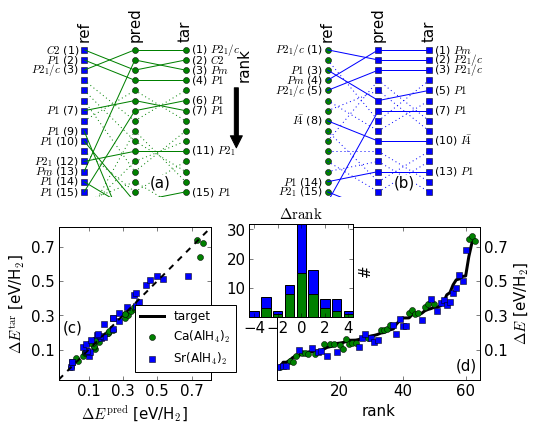

In [23]:
def final():
    
    Ep_ca = [o.Et for o in pred_ca_native]
    Ep_sr = [o.Et for o in pred_sr_native]
    Ep_all = [o.Et for o in pred_all_native]
    Et_ca = [o.Et for o in true_ca_native]
    Et_sr = [o.Et for o in true_sr_native]
    Et_all = [o.Et for o in true_all_native]
    
    fig = plt.figure(figsize=(8,6))
    gs0 = gridspec.GridSpec(2, 1)
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1])

    ax1 = fig.add_subplot(gs1[0,0])
    ax2 = fig.add_subplot(gs1[0,1])
    ax3 = fig.add_subplot(gs2[0,0])
    ax4 = fig.add_subplot(gs2[0,1])

    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    
    N_order = 15
    def order_plot(ref, pred, true, ax, **pk):
        
        def plot_marker(coord, **plt_kwargs):
            ax.plot(coord[0], coord[1], **plt_kwargs)
        
        N = len(true)
        order_true = range(N)
        order_pred = np.argsort([o.Et for o in pred]).tolist()
        order_ref = np.argsort([o.Et for o in ref]).tolist()
        marker_coord_true = zip([3 for _ in range(N)], order_true)
        marker_coord_pred = zip([2 for _ in range(N)], order_pred)
        marker_coord_ref = zip([1 for _ in range(N)], order_ref)
        pred_order = []
        for i in range(N):
            ri = order_ref[i]
            pi = order_pred[i]
            #print "%2d %2d %2d" % (ri, pi, i)
            r, p, t = ref[ri], pred[pi], true[i]
            pred_order.append(pi)
            
            ax.plot([1], [ri], **dict(marker=pk['rm'], color=pk['rc'], ls=''))
            ax.plot([2], [pi], **dict(marker=pk['tm'], color=pk['tc'], ls=''))
            ax.plot([3], [i], **dict(marker=pk['tm'], color=pk['tc'], ls=''))
            if abs(pi - i) < 2:
                ls = '-'
            else:
                ls = ':'
            ax.plot([1, 2], [ri, pi], color=pk['tc'], ls=ls)
            ax.plot([2, 3], [pi, i], color=pk['tc'], ls=ls)
            
            spg_true = get_symmetry(i, true)
            spg_ref = get_symmetry(i, ref)
            if ls == '-':
                if i < N_order:
                    ax.text(3.1, i+0.3, 
                            "(%d) %s" % (i+1, spg_latex(spg_true)), 
                            fontsize=11)
                if ri < N_order:
                    ax.text(0.9, ri+0.3, 
                            "%s (%d)" % (spg_latex(spg_ref), ri+1), 
                            fontsize=11, 
                            ha='right')
        ax.text(.85, -0.8, 'ref', rotation=90, va='bottom', fontsize=15)
        ax.text(1.85, -0.8, 'pred', rotation=90, va='bottom', fontsize=15)
        ax.text(2.85, -0.8, 'tar', rotation=90, va='bottom', fontsize=15)
            
        ax.set_xlim(0,4)
        ax.set_ylim(N_order - 0.5,-0.5)
        ax.axis('off')
        return pred_order
        
    ca_order = order_plot(ref_ca_native, pred_ca_native, true_ca_native, ax1, tm='o', rm='s', tc='g', rc='b')
    sr_order = order_plot(ref_sr_native, pred_sr_native, true_sr_native, ax2, tm='s', rm='o', tc='b', rc='g')
    print len(ca_order)
    print ca_order
    
    N_scatter = 32
    Ep_all = np.array(list(qtk.flatten([Ep_sr[:N_scatter], Et_ca[:N_scatter]])))
    Ep_all_ca = np.array(list(qtk.flatten([[np.nan for _ in range(N_scatter)], Ep_ca[:N_scatter]])))
    Ep_all_sr = np.array(list(qtk.flatten([Ep_sr[:N_scatter], [np.nan for _ in range(N_scatter)]])))
    Et_all = list(qtk.flatten([Et_sr[:N_scatter], Et_ca[:N_scatter]]))
    Et_key = np.argsort(Et_all)
    tmp = list(qtk.flatten([Et_all, Ep_all.tolist()]))
    E_max, E_min = max(tmp), min(tmp)
    p_max = E_max + 0.1 * (E_max - E_min)
    p_min = E_min - 0.1 * (E_max - E_min)
    
    ax3.plot(Ep_ca[:N_scatter], Et_ca[:N_scatter], ls='', marker='o', color='g')
    ax3.plot(Ep_sr[:N_scatter], Et_sr[:N_scatter], ls='', marker='s', color='b')
    ax3.plot([p_min, p_max], [p_min, p_max], ls='--', lw=2, color='k')
    ax3.set_xlim(p_min, p_max)
    ax3.set_ylim(p_min, p_max)
    ax3.set_aspect('equal')
    ax3.set_ylabel(r'$\Delta E^{\rm tar}$ [eV/H$_2$]', fontsize=15)
    ax3.set_xlabel(r'$\Delta E^{\rm pred}$ [eV/H$_2$]', fontsize=15)
    ax3.xaxis.set_ticks([0.1, 0.3, 0.5, 0.7])
    ax3.xaxis.set_tick_params(labelsize=15)
    ax3.yaxis.set_ticks([0.1, 0.3, 0.5, 0.7])
    ax3.yaxis.set_tick_params(labelsize=15)
    
    ax4.plot(sorted(Et_all), color='k', lw=3, label=r'target')
    ax4.plot(Ep_all_ca[Et_key], ls='', marker='o', color='g', label=r'Ca(AlH$_4$)$_2$')
    ax4.plot(Ep_all_sr[Et_key], ls='', marker='s', color='b', label=r'Sr(AlH$_4$)$_2$')
    ax4.set_ylim(p_min, p_max)
    ax4.set_xlim(0, 2*N_scatter + 0.5)
    ax4.set_ylabel(r'$\Delta E$ [eV/H$_2$]', fontsize=15)
    ax4.set_xlabel('rank', fontsize=15)
    ax4.yaxis.set_ticks([0.1, 0.3, 0.5, 0.7])
    ax4.yaxis.set_tick_params(labelsize=15)
    ax4.xaxis.set_ticks([20, 40, 60])
    ax4.xaxis.set_tick_params(labelsize=15)
    
    y = sorted(Et_all)
    x = Ep_all[Et_key]
    y_fit = qtk.ML.l2_fit(x,y)
    print qtk.ML.error_measure(y, y_fit)
    print np.polyfit(x, y, 1)
    
    ca_diff = np.array(ca_order) - np.arange(len(ca_order))
    sr_diff = np.array(sr_order) - np.arange(len(sr_order))
    ca_diff = np.append(ca_diff, [np.nan for _ in range(len(sr_diff) - len(ca_diff))])
    hist_data = np.stack([ca_diff, sr_diff]).T
    #h_max = np.max(abs(hist_data[np.invert(np.isnan(hist_data))]))
    h_max = 4.5
    ax_width = 0.18
    ax_i = plt.axes([.5, .27, ax_width, ax_width * 1.2])
    ax_i.xaxis.set_ticks([-4, -2, 0, 2, 4])
    ax_i.xaxis.set_tick_params(labelsize=15)
    ax_i.set_xlabel(r'$\Delta\mathrm{rank}$', fontsize=15)
    ax_i.xaxis.set_label_position("top")
    ax_i.yaxis.set_ticks([10, 20,30])
    ax_i.yaxis.set_tick_params(labelsize=15)
    ax_i.set_ylabel('#', fontsize=15)
    ax_i.yaxis.set_label_position("right")
    print np.ones(42)[abs(hist_data[:,0][:-2]) < 2].sum()
    print np.ones(44)[abs(hist_data[:,1]) < 2].sum()
    
    #plt.figure()
    #plt.hist(hist_data, bins=5, color=['g', 'b'], range=(-h_max, h_max), stacked=True)
    ax_i.hist(hist_data, bins=9, color=['g', 'b'], range=(-h_max, h_max), stacked=True)
    
    ax1.text(2.3, 13.5, '(a)', fontsize=15, bbox=dict(fc="w",ec="w", pad=0))
    ax2.text(2.3, 13.5, '(b)', fontsize=15, bbox=dict(fc="w",ec="w", pad=0))
    ax3.text(-0.05,0.2, '(c)', fontsize=15, bbox=dict(fc="w",ec="w", pad=0))
    ax4.text(57,-0.02, '(d)', fontsize=15, bbox=dict(fc="w",ec="w", pad=0))
    ax4.legend(numpoints=1, loc=(-0.7, 0.05))
    ax1.annotate('rank', xy=(4., 10), xytext=(4., 1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 rotation=90, fontsize=15)
    
    
final()
plt.savefig('order_plot.pdf')

In [15]:
np.append(np.arange(10), [np.nan, np.nan])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  nan,
        nan])

# final plot

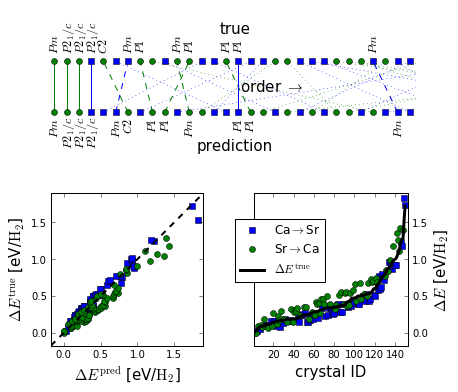

In [16]:
N = 150
Nt = 30
#Nv = len(Er_Ev)
#Nva = len(Evp_ref)

p_max = max(Er_all[:N])
p_min = min(Er_all[:N])
y_min = float(p_min - (p_max - p_min) / 10.)
y_max = float(p_max + (p_max - p_min) / 10.)

fig = plt.figure(figsize=(6.7,6))

gs0 = gridspec.GridSpec(2, 1)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1])

#gs = gridspec.GridSpec(2,2)
ax1 = fig.add_subplot(gs1[0, 0])
ax_scatter = fig.add_subplot(gs2[0, 0])
ax_order = fig.add_subplot(gs2[0, 1])


ax_order.plot(index_ca, Ep_ca, ls='', marker='s', label=r'Ca$\rightarrow$Sr')
ax_order.plot(index_sr, Ep_sr, ls='', marker='o', label=r'Sr$\rightarrow$Ca')
ax_order.plot(index_all[:N], Er_all[:N], ls='-', color='k', lw=3, label=r'$\Delta E^{\mathrm{true}}$')
#ax_order.plot(1000, 1000, color='r', marker='^', label=r'$E_v^{\mathrm{AlGaAs}}$', ls='')
#ax_order.plot(1000, 1000, color='m', marker='v', label=r'$E_v^{\mathrm{AlGaP}}$', ls='')
ax_order.set_xlabel('crystal ID', fontsize=15)
ax_order.set_ylabel('$\Delta E$ [eV/$\mathrm{H}_2$]', fontsize=15)
ax_order.yaxis.tick_right()
ax_order.yaxis.set_label_position("right")
# ax_order.xaxis.tick_top()
# ax_order.xaxis.set_label_position("top")
ax_order.set_xlim([1, N+3])
ax_order.set_ylim([y_min, y_max])
ax_order.legend(loc=(-0.12, 0.42), numpoints=1)
ax_order.set_zorder(100)
ax_order.set_aspect(float(N)/(y_max - y_min))

ax_scatter.plot(Ep_ca[:N], Er_ca[:N], ls='', marker='s')
ax_scatter.plot(Ep_sr[:N], Er_sr[:N], ls='', marker='o')
ax_scatter.plot([y_min, y_max], [y_min, y_max], color='k', ls='--', lw=2)
ax_scatter.set_aspect('equal')
ax_scatter.set_xlim(y_min, y_max)
ax_scatter.set_ylim(y_min, y_max)
# ax_scatter.xaxis.tick_top()
# ax_scatter.xaxis.set_label_position("top")
ax_scatter.set_ylabel('$\Delta E^{\mathrm{true}}$ [eV/$\mathrm{H}_2$]', fontsize=15)
ax_scatter.set_xlabel('$\Delta E^{\mathrm{pred}}$ [eV/$\mathrm{H}_2$]', fontsize=15)


order_true = index_all
order_pred = (np.argsort(Ep_all)+1).tolist()
conn_x_list = zip(order_pred, order_true)
conn_y_list = zip([1 for _ in index_all], [2 for _ in index_all])
for i in range(len(conn_x_list)):
    spg_ref = get_symmetry(i, ref_all)
    spg_pred = get_symmetry(i, pred_all)
    cx = conn_x_list[i]
    cy = conn_y_list[i]
    if cx[0] < Nt and cx[1] < Nt:
        if abs(cx[0] - cx[1]) == 0:
            if cx[1] in index_ca:
                ax1.plot(cx, cy, color='b', marker='s')
            elif cx[1] in index_sr:
                ax1.plot(cx, cy, color='g', marker='o')
            x, y = cx[0], cy[0]
            ax1.annotate(
                spg_latex(spg_pred), 
                xy=(x - 0.5, y - 0.3), 
                xytext=(x - 0.5, y - 0.3),
                rotation = 90,
                fontsize=12,
            )
            x, y = cx[1], cy[1]
            ax1.annotate(
                spg_latex(spg_ref), 
                xy=(x - 0.5, y + 0.15), 
                xytext=(x - 0.5, y + 0.15),
                rotation = 90,
                fontsize=12,
                va='bottom',
            )
        elif abs(cx[0] - cx[1]) <= 3:
            if cx[1] in index_ca:
                ax1.plot(cx, cy, color='b', marker='s', ls='--')
            elif cx[1] in index_sr:
                ax1.plot(cx, cy, color='g', marker='o', ls='--')
            x, y = cx[0], cy[0]
            ax1.annotate(
                spg_latex(spg_pred),
                xy=(x - 0.5, y - 0.3), 
                xytext=(x - 0.5, y - 0.3),
                rotation = 90,
                fontsize=12,
            )
            x, y = cx[1], cy[1]
            ax1.annotate(
                spg_latex(spg_ref),
                xy=(x - 0.5, y + 0.15), 
                xytext=(x - 0.5, y + 0.15),
                rotation = 90,
                fontsize=12,
                va='bottom',
            )
        else:
            if cx[1] in index_ca:
                ax1.plot(cx, cy, color='b', marker='s', ls=':',lw=0.5)
            elif cx[1] in index_sr:
                ax1.plot(cx, cy, color='g', marker='o', ls=':',lw=0.5)
    else:
        if cx[1] in index_ca:
            ax1.plot(cx, cy, color='b', marker='s', ls=':',lw=0.5)
        elif cx[1] in index_sr:
            ax1.plot(cx, cy, color='g', marker='o', ls=':',lw=0.5)
ax1.text((Nt+1.5)/2., 0.25, "prediction", fontsize=15, ha='center')
ax1.text((Nt+1.5)/2. + 3, 1.4, r"order $\rightarrow$", fontsize=15, ha='center')
ax1.text((Nt+1.5)/2., 2.55, "true", fontsize=15, ha='center')
ax1.set_ylim(0,3)
ax1.set_xlim(0,Nt+0.5)
ax1.axis('off')


# # histogram inset
# order_diff = np.abs(np.array(order_pred) - np.array(order_true))
# ax_i = plt.axes([.565, .54, .32, .38])
# ax_i.hist(order_diff, bins=10, color='0.7')
# ax_i.set_xlabel(r'|$\Delta$rank|', fontsize=15)
# ax_i.set_ylabel('counts', fontsize=15)
# ax_i.yaxis.tick_right()
# ax_i.yaxis.set_label_position("right")
# ax_i.xaxis.tick_top()
# ax_i.xaxis.set_label_position("top")



#plt.tight_layout(w_pad=-1)
plt.savefig('order_plot.pdf')

/home/samio/local/miniconda2/lib/python2.7/site-packages/matplotlib-2.0.0-py2.7-linux-x86_64.egg/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


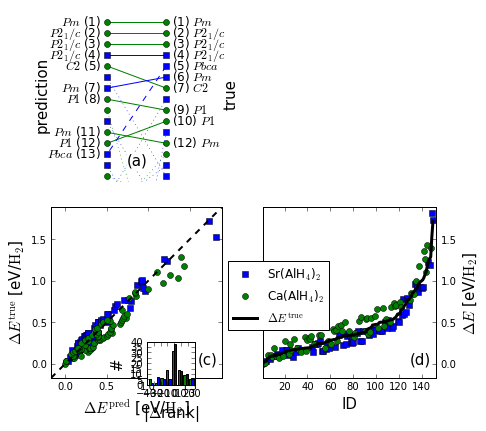

In [17]:
N = 150
Nt = 15
#Nv = len(Er_Ev)
#Nva = len(Evp_ref)

p_max = max(Er_all[:N])
p_min = min(Er_all[:N])
y_min = float(p_min - (p_max - p_min) / 10.)
y_max = float(p_max + (p_max - p_min) / 10.)

fig = plt.figure(figsize=(6.7,6))

gs0 = gridspec.GridSpec(2, 1)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])
gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1])

#gs = gridspec.GridSpec(2,2)
ax1 = fig.add_subplot(gs1[0, 0])
ax_noshow = fig.add_subplot(gs1[0, 1])
ax_scatter = fig.add_subplot(gs2[0, 0])
ax_order = fig.add_subplot(gs2[0, 1])

ax_noshow.axis('off')


ax_order.plot(index_ca, Ep_ca, ls='', marker='s', label=r'Sr(AlH$_4$)$_2$')
ax_order.plot(index_sr, Ep_sr, ls='', marker='o', label=r'Ca(AlH$_4$)$_2$')
ax_order.plot(index_all[:N], Er_all[:N], ls='-', color='k', lw=3, label=r'$\Delta E^{\mathrm{true}}$')
#ax_order.plot(1000, 1000, color='r', marker='^', label=r'$E_v^{\mathrm{AlGaAs}}$', ls='')
#ax_order.plot(1000, 1000, color='m', marker='v', label=r'$E_v^{\mathrm{AlGaP}}$', ls='')
ax_order.set_xlabel('ID', fontsize=15)
ax_order.set_ylabel('$\Delta E$ [eV/$\mathrm{H}_2$]', fontsize=15)
ax_order.yaxis.tick_right()
ax_order.yaxis.set_label_position("right")
# ax_order.xaxis.tick_top()
# ax_order.xaxis.set_label_position("top")
ax_order.set_xlim([1, N+3])
ax_order.set_ylim([y_min, y_max])
ax_order.set_zorder(100)
ax_order.set_aspect(float(N)/(y_max - y_min))

ax_scatter.plot(Ep_ca[:N], Er_ca[:N], ls='', marker='s')
ax_scatter.plot(Ep_sr[:N], Er_sr[:N], ls='', marker='o')
ax_scatter.plot([y_min, y_max], [y_min, y_max], color='k', ls='--', lw=2)
ax_scatter.set_aspect('equal')
ax_scatter.set_xlim(y_min, y_max)
ax_scatter.set_ylim(y_min, y_max)
# ax_scatter.xaxis.tick_top()
# ax_scatter.xaxis.set_label_position("top")
ax_scatter.set_ylabel('$\Delta E^{\mathrm{true}}$ [eV/$\mathrm{H}_2$]', fontsize=15)
ax_scatter.set_xlabel('$\Delta E^{\mathrm{pred}}$ [eV/$\mathrm{H}_2$]', fontsize=15)


order_true = index_all
order_pred = (np.argsort(Ep_all)+1).tolist()
conn_x_list = zip(order_pred, order_true)
conn_y_list = zip([2 for _ in index_all], [1 for _ in index_all])
for i in range(len(conn_x_list)):
    spg_ref = get_symmetry(i, ref_all)
    spg_pred = get_symmetry(i, pred_all)
    cx = conn_x_list[i]
    cy = conn_y_list[i]
    if cx[0] < Nt and cx[1] < Nt:
        if abs(cx[0] - cx[1]) <= 5:
            if cx[1] in index_ca:
                ax1.plot(cy, cx, color='b', marker='s')
            elif cx[1] in index_sr:
                ax1.plot(cy, cx, color='g', marker='o')
            x, y = cx[0], cy[0]
            ax1.annotate(
                '(%d) ' % conn_x_list[i][0] + spg_latex(spg_pred), 
                xy=(y + 0.1, x+0.3), 
                xytext=( y + 0.1, x+0.3),
                #rotation = 90,
                fontsize=12,
            )
            x, y = cx[1], cy[1]
            ax1.annotate(
                spg_latex(spg_ref) + ' (%d)' % conn_x_list[i][1], 
                xy=(y - 0.1, x+0.3), 
                xytext=(y - 0.1, x+0.3),
                #rotation = 90,
                fontsize=12,
                ha='right',
            )
        elif abs(cx[0] - cx[1]) <= 10:
            if cx[1] in index_ca:
                ax1.plot(cy, cx, color='b', marker='s', ls='--')
            elif cx[1] in index_sr:
                ax1.plot(cy, cx, color='g', marker='o', ls='--')
            x, y = cx[0], cy[0]
            ax1.annotate(
                '(%d) ' % conn_x_list[i][0] + spg_latex(spg_pred),
                xy=(y + 0.1, x+0.3), 
                xytext=(y + 0.1, x+0.3),
                #rotation = 90,
                fontsize=12,
            )
            x, y = cx[1], cy[1]
            ax1.annotate(
                spg_latex(spg_ref) + ' (%d)' % conn_x_list[i][1],
                xy=(y - 0.1, x+0.3), 
                xytext=(y - 0.1, x+0.3),
                #rotation = 90,
                fontsize=12,
                ha='right',
            )
        else:
            if cx[1] in index_ca:
                ax1.plot(cy, cx, color='b', marker='s', ls=':',lw=0.5)
            elif cx[1] in index_sr:
                ax1.plot(cy, cx, color='g', marker='o', ls=':',lw=0.5)
    else:
        if cx[1] in index_ca:
            ax1.plot(cy, cx, color='b', marker='s', ls=':',lw=0.5)
        elif cx[1] in index_sr:
            ax1.plot(cy, cx, color='g', marker='o', ls=':',lw=0.5)
ax1.text(-0.1, (Nt+1.5)/2.-3, "prediction", rotation = 90, fontsize=15, ha='center')
#ax1.text(1.4, (Nt+1.5)/4. + 3, r"order $\rightarrow$", rotation = -90, fontsize=15, ha='center')
ax1.text(3.1, (Nt+1.5)/2.-1, "true", rotation = 90, fontsize=15, ha='center')
ax1.set_xlim(0,3)
ax1.set_ylim(Nt+0.5,0)
ax1.axis('off')
ax1.fill_betweenx([0,3], 15.5, 32, color='w', zorder=100)


# histogram inset
order_diff = np.array(order_pred) - np.array(order_true)
hist_data = np.stack([order_diff[np.array(index_ca)-1], order_diff[np.array(index_sr) - 1]]).T

ax_i = plt.axes([.3, .1, .1, .1])
ax_i.hist(hist_data, bins=8, color=['g', 'b'], stacked=False)
ax_i.set_xlabel(r'|$\Delta$rank|', fontsize=15)
ax_i.set_ylabel('#', fontsize=15)

ax_order.legend(loc=(-0.2, 0.28), numpoints=1)

cc = 'w'
ax1.text(1.34,14, '(a)', fontsize=15, bbox=dict(fc=cc,ec=cc, pad=0))
#ax_i.text(34, 10, '(b)', fontsize=15, bbox=dict(fc=cc,ec=cc, pad=0))
ax_scatter.text(1.6, 0, '(c)', fontsize=15, bbox=dict(fc=cc,ec=cc, pad=0))
ax_order.text(130, 0, '(d)', fontsize=15, bbox=dict(fc=cc,ec=cc, pad=0))

plt.tight_layout(w_pad=-1)
plt.savefig('order_plot.pdf')

# Second version

# Analysis

In [18]:
E_fit = qtk.ML.l2_fit(Ep_all, Er_all)
print qtk.ML.error_measure(Er_all, E_fit)

(0.96141873753108609, 0.11806596251988263, 0.083227114301860194)


In [19]:
print qtk.ML.error_measure

<function error_measure at 0x2b645073e320>


In [20]:
len(order_diff[order_diff < 10]) / float(len(order_diff))


0.8081395348837209

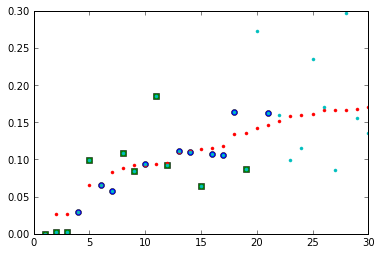

In [21]:
Ns = 10
plt.plot(index_ca[:Ns], Ep_ca[:Ns], ls='', marker='o')
plt.plot(index_sr[:Ns], Ep_sr[:Ns], ls='', marker='s')
plt.plot(index_all[:2*Ns+10], Er_all[:2*Ns+10], ls='', marker='.')
plt.plot(index_all[:2*Ns+10], Ep_all[:2*Ns+10], ls='', marker='.')



9.63953488372 9.45357418652


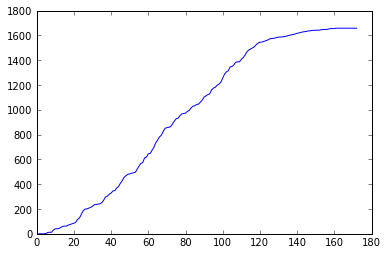

In [22]:
order_diff = np.abs(np.array(order_pred) - np.array(order_true))
plt.plot(order_true, order_diff.cumsum())
print order_diff.mean(), order_diff.std()

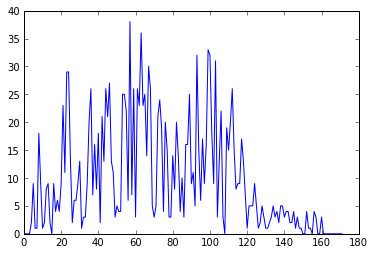

In [23]:
plt.plot(order_diff)

(array([ 62.,  32.,  21.,  13.,   9.,  11.,  14.,   4.,   4.,   2.]),
 array([  0. ,   3.8,   7.6,  11.4,  15.2,  19. ,  22.8,  26.6,  30.4,
         34.2,  38. ]),
 <a list of 10 Patch objects>)

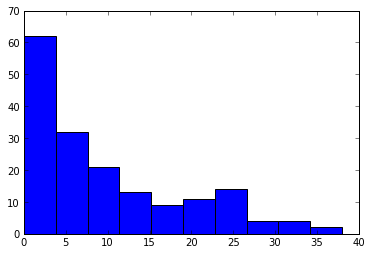

In [24]:
plt.hist(order_diff, bins=10)

In [25]:
def normal(*args):
    return np.random.normal(loc=order_diff.mean(), scale=order_diff.std())

In [26]:
np.random.normal
sp.stats.kstest(order_diff, normal)

KstestResult(statistic=3.9992657287662352, pvalue=nan)

In [27]:
type(ref_raw[0])

qctoolkit.QM.qmcode.abinit.out

(0, 20)

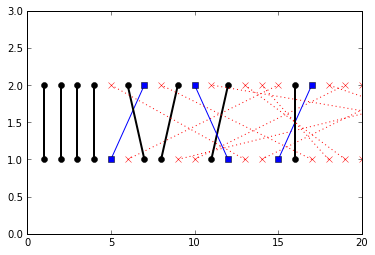

In [28]:
Nt = 170
order_true = index_all[:Nt]
order_pred = (np.argsort(Ep_all)[:Nt]+1).tolist()
conn_x_list = zip(order_true, order_pred)
conn_y_list = zip([1 for _ in range(Nt)], [2 for _ in range(Nt)])
for i in range(Nt):
    cx = conn_x_list[i]
    cy = conn_y_list[i]
    if abs(cx[0] - cx[1]) <= 1:
        plt.plot(cx, cy, color='k', marker='o', lw=2)
    elif abs(cx[0] - cx[1]) <= 3:
        plt.plot(cx, cy, color='b', marker='s')
    else:
        plt.plot(cx, cy, color='r', marker='x', ls=':')
plt.ylim(0,3)
plt.xlim(0,20)

In [29]:
print order_true[:10]
print order_pred[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 2, 3, 4, 7, 15, 6, 9, 27, 19]


In [30]:
ref_ca[3].name

'Ca_p_04-Ca.out'

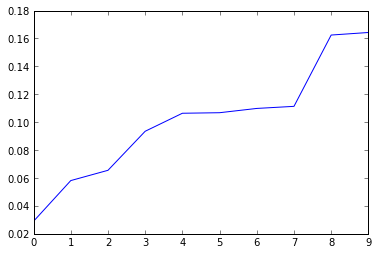

In [31]:
plt.plot(sorted([o.Et for o in pred_ca[:10]]))

# Correlation score

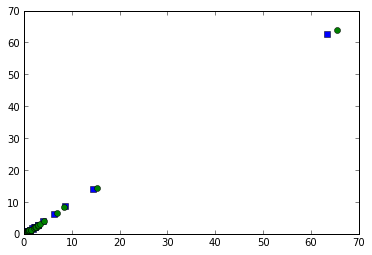

In [32]:
plt.plot(Ep_ca[:N], Er_ca[:N], ls='', marker='s')
plt.plot(Ep_sr[:N], Er_sr[:N], ls='', marker='o')

(0.99985564028778662, 8.3933351729878687e-303)

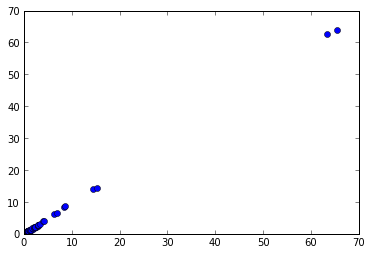

In [33]:
N = 200
x, y = Ep_all[:N], Er_all[:N]
plt.plot(x, y, ls='', marker='o')

sp.stats.pearsonr(x, y)

In [34]:
print sp.stats.pointbiserialr(x, y)

print sp.stats.ks_2samp(x, y)

print sp.stats.kendalltau(x, y)

print sp.stats.weightedtau(x,y)

print sp.stats.ranksums(x, y)

print sp.stats.ansari(x, y)

print sp.stats.mood(x, y)

print sp.stats.binned_statistic(x, y)

print sp.stats.spearmanr(x, y)

PointbiserialrResult(correlation=0.99985564028778662, pvalue=8.3933351729878687e-303)
Ks_2sampResult(statistic=0.058139534883720978, pvalue=0.92596458721149089)
KendalltauResult(correlation=0.85209998348882954, pvalue=8.2357842221166648e-62)
WeightedTauResult(correlation=0.94841200044178264, pvalue=nan)
RanksumsResult(statistic=0.16373049540033416, pvalue=0.86994330964235966)
AnsariResult(statistic=14784.0, pvalue=0.83846836401848512)
(0.45938982732920575, 0.64595425203866597)
BinnedStatisticResult(statistic=array([  0.64851084,   7.86016863,  14.22990279,          nan,
                nan,          nan,          nan,          nan,
                nan,  63.24625994]), bin_edges=array([  0.        ,   6.54898764,  13.09797529,  19.64696293,
        26.19595057,  32.74493822,  39.29392586,  45.8429135 ,
        52.39190115,  58.94088879,  65.48987643]), binnumber=array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 